# Tune GPT2 to generate controlled sentiment reviews
> Optimise GPT2 to produce IMDB movie reviews with controlled sentiment using a BERT sentiment classifier for rewards.

**WARNING:** We often experienced loss spikes in this examples which caused model training to fail or slow down. There is a [GitHub issue](https://github.com/lvwerra/trl/issues/101) to track the issue.

<div style="text-align: center">
<img src='https://huggingface.co/datasets/trl-internal-testing/example-images/resolve/main/images/gpt2-ctrl-training-setup.png' width='600'>
<p style="text-align: center;"> <b>Figure:</b> Experiment setup to tune GPT2. The yellow arrows are outside the scope of this notebook, but the trained models are available through Hugging Face. </p>
</div>


The experiment setup is very similar to the positive sentiment notebook. However, in this notebook we fine-tune GPT2 (small) to generate **controlled** movie reviews based on the IMDB dataset. The model gets the target sentiment and 5 tokens from a real review and is tasked to produce continuations with the targeted sentiment. The reward for the continuations is calculated with the logits of a BERT sentiment classifier. That reward is then used for PPO training.

## Setup experiment

### Import dependencies

In [1]:
# !pip install trl==0.11.4

In [2]:
# %load_ext autoreload
# %autoreload 2

In [3]:
import random
import torch
import wandb
import time
import os
from tqdm.auto import tqdm
import numpy as np
import pandas as pd
from datasets import Dataset, DatasetDict
from random import choices
import matplotlib.pyplot as plt
import sys
sys.path.append('/root/autodl-tmp/CommitFit')
from sklearn.model_selection import train_test_split
import ensemble_model.preprocesser as preprocesser 
import ensemble_model.combined_model as cm 
from torch.utils.data import Dataset, DataLoader
from transformers import BertModel, BertTokenizer, RobertaModel, RobertaTokenizer
import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score, precision_recall_curve
import torch.nn.functional as F
tqdm.pandas()
import sys
sys.path.append('/root/autodl-tmp/commit_generative_reinforcement_learning')
# from datasets import load_dataset

from transformers import AutoTokenizer, pipeline, AutoModelForCausalLM

from trl import (
    PPOTrainer,
    PPOConfig,
    AutoModelForCausalLMWithValueHead,
    create_reference_model,
)
from trl import AutoModelForSeq2SeqLMWithValueHead
# from trl.experimental.ppo import PPOTrainer

2026-01-07 16:45:38.075176: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2026-01-07 16:45:38.148582: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2026-01-07 16:45:39.399121: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
/root/miniconda3/lib/python3.12/site-packages/keras/src/export/tf2onnx_lib.py:8:

### Configuration

In [4]:
# commit_pipe_kwargs = {"top_k": None, "function_to_apply": "none"}

config = PPOConfig(
    model_name="./outputs/checkpoint-936",
    steps=51200,
    learning_rate=1.41e-5,
    remove_unused_columns=False,
    log_with="wandb",
    batch_size=4,
    mini_batch_size=4,
)

txt_in_len = 2048
txt_out_len = 512
seed = 1


/root/autodl-tmp/commit_generative_reinforcement_learning/trl/trainer/ppo_config.py:207: FutureWarning: `PPOConfig` is deprecated and will be removed in the future. Please use `PPOv2Config` with `PPOv2Trainer` instead.
  warnings.warn(


You can see that we load a GPT2 model called `gpt2_imdb`. This model was additionally fine-tuned on the IMDB dataset for 1 epoch with the huggingface [script](https://github.com/huggingface/transformers/blob/master/examples/run_language_modeling.py) (no special settings). The other parameters are mostly taken from the original paper ["Fine-Tuning Language Models from Human Preferences"](
https://huggingface.co/papers/1909.08593). This model as well as the BERT model is available in the Huggingface model zoo [here](https://huggingface.co/models). The following code should automatically download the models.

## Load data and models

### Load pre-trained GPT2 language models

We load the GPT2 model with a value head and the tokenizer. We load the model twice; the first model is optimized while the second model serves as a reference to calculate the KL-divergence from the starting point. This serves as an additional reward signal in the PPO training to make sure the optimized model does not deviate too much from the original language model.

In [5]:
policy_name = config.model_name
tokenizer = AutoTokenizer.from_pretrained(policy_name)

# 1) policy / ref policy: Seq2Seq + value head
policy = AutoModelForSeq2SeqLMWithValueHead.from_pretrained(policy_name)
ref_policy = AutoModelForSeq2SeqLMWithValueHead.from_pretrained(policy_name)

In [6]:
# 确保 eos_token_id 是正数
print("eos_token_id:", tokenizer.eos_token_id)
print("pad_token_id:", tokenizer.pad_token_id)

eos_token_id: 2
pad_token_id: 0


### Load IMDB dataset
The IMDB dataset contains 50k movie review annotated with "positive"/"negative" feedback indicating the sentiment.  We load the IMDB dataset into a DataFrame and filter for comments that are at least 500 characters long and take the first 1000 characters of each comment. The first filter we apply to avoid comments that are less than `txt_in_len` token long and the second to avoid tokenizing way more text than we actually need.

In [7]:
import pandas as pd
from datasets import Dataset, DatasetDict
from transformers import AutoTokenizer
from sklearn.model_selection import train_test_split
# =========================
# 0) 配置
# =========================
CSV_PATH = "/root/autodl-tmp/CommitFit/dataset/Ghadhab/dataset.csv"
MODEL_NAME = "/root/autodl-tmp/models/codet5-base"

# =========================
# 2) 读 CSV -> Dataset -> split
# =========================
df = pd.read_csv(CSV_PATH)
label2id={'Adaptive':0, 'Corrective':1, 'Perfective':2}
df = df.replace({"labels": label2id})
df

import re

def compress_diff_minimal(
    diff_text: str,
    max_changed_lines: int = 120,   # 最多保留多少条 +/-
    max_chars: int = 3500,          # 最终硬截断（字符）
) -> str:
    if not diff_text:
        return ""

    lines = diff_text.splitlines()
    kept = []
    changed_cnt = 0

    for ln in lines:
        # 文件头
        if ln.startswith("diff --git "):
            kept.append(ln)
            continue

        # 跳过噪声行
        if ln.startswith(("index ", "new file mode", "deleted file mode", "similarity index", "rename from", "rename to")):
            continue
        if ln.startswith(("--- ", "+++ ")):  # 这两行通常很长且重复文件名，可选保留；这里跳过以更“最小”
            continue
        if "GIT binary patch" in ln:
            continue

        # hunk 头
        if ln.startswith("@@"):
            kept.append(ln)
            continue

        # 只保留变更行（排除+++ / ---）
        if (ln.startswith("+") and not ln.startswith("+++")) or (ln.startswith("-") and not ln.startswith("---")):
            kept.append(ln)
            changed_cnt += 1
            if changed_cnt >= max_changed_lines:
                kept.append("... (diff truncated: too many changed lines)")
                break
            continue

        # 其他上下文行：不保留（最小改动版）
        # 如果你想保留少量上下文，把这里改成“遇到变更行附近保留1-2行”即可

    out = "\n".join(kept).strip()
    if len(out) > max_chars:
        out = out[:max_chars] + "\n... (diff truncated: max_chars)"
    return out


def build_prompt(diff_compact: str) -> str:
    return (
        "Please write a concise commit message that summarizes the following code changes:"
        "<DIFF>\n"
        f"{diff_compact}\n"
        "</DIFF>\n\n"
        "Commit message:"
    )



df["diff_compact"] = df["diffs"].map(compress_diff_minimal)
df["gen_prompt"] = df["diff_compact"].map(build_prompt)   # 不要 label 版本

df = df.rename(columns={'msgs':'target_text','diff_compact':'source_text'})
label2id={'Adaptive':0, 'Corrective':1, 'Perfective':2}
df = df.replace({"labels": label2id})
df

,user,repo,commit,labels,target_text,diffs,feature,source_text
0,ponsonio,RxJava,0531b8bff5c14d9504beefb4ad47f473e3a22932,2,Change hasException to hasThrowable--,diff --git a/rxjava-core/src/main/java/rx/Noti...,"[1, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",diff --git a/rxjava-core/src/main/java/rx/Noti...
1,ponsonio,RxJava,0950c46beda335819928585f1262dfe1dca78a0b,0,Trying to extend the Scheduler interface accor...,diff --git a/rxjava-core/src/main/java/rx/Sche...,"[2, 44, 0, 0, 30, 0, 0, 1, 18, 0, 0, 0, 0, 0, ...",diff --git a/rxjava-core/src/main/java/rx/Sche...
2,ponsonio,RxJava,0f92fdd8e6422d5b79c610a7fd8409d222315a49,0,RunAsync method for outputting multiple values--,diff --git a/rxjava-contrib/rxjava-async-util/...,"[2, 53, 0, 0, 42, 0, 0, 1, 45, 1, 0, 0, 0, 0, ...",diff --git a/rxjava-contrib/rxjava-async-util/...
3,ponsonio,RxJava,100f571c9a2835d5a30a55374b9be74c147e031f,1,forEach with Action1 but not Observer--I re-re...,diff --git a/language-adaptors/rxjava-groovy/s...,"[1, 5, 122, 9, 10, 9, 4, 1, 5, 18, 2, 0, 0, 0,...",diff --git a/language-adaptors/rxjava-groovy/s...
4,ponsonio,RxJava,191f023cf5253ea90647bc091dcaf55ccdce81cc,1,1.x: Fix Completable swallows- OnErrorNotImple...,diff --git a/src/main/java/rx/Completable.java...,"[1, 1, 0, 0, 0, 0, 0, 1, 21, 0, 0, 0, 0, 0, 0,...",diff --git a/src/main/java/rx/Completable.java...
...,...,...,...,...,...,...,...,...
1776,jenkinsci,clearcase-plugin,51e9da224f80254476a7dc446bca817b505381d8,2,Use a temporary file to decrease memory consum...,diff --git a/src/main/java/hudson/plugins/clea...,"[2, 12, 0, 4, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,...",diff --git a/src/main/java/hudson/plugins/clea...
1777,jexp,batch-import,609d6c4b1eea2c33d9fb950fcbb9ba9dc1f80fc3,2,added a more memory efficient structure for st...,diff --git a/src/main/java/org/neo4j/batchimpo...,"[10, 159, 29, 35, 9, 2, 1, 5, 106, 0, 4, 8, 0,...",diff --git a/src/main/java/org/neo4j/batchimpo...
1778,hdiv,hdiv,19b650c78a1c76f4fd90274d7f163f863c0d39e4,2,Memory and performance optimizations,diff --git a/hdiv-config/src/main/java/org/hdi...,"[31, 302, 131, 140, 170, 89, 53, 7, 88, 14, 17...",diff --git a/hdiv-config/src/main/java/org/hdi...
1779,casidiablo,persistence,d7bf95159df37a3d338ca267dddd3d26b38ec37c,2,Now it is possible to specify the sqlite open ...,diff --git a/pom.xml b/pom.xml\nindex 394263b....,"[5, 57, 20, 9, 21, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","diff --git a/pom.xml b/pom.xml\n@@ -23,5 +23,5..."


In [8]:

train, temp_df = train_test_split(df, test_size=0.3, random_state=42)
val, test = train_test_split(temp_df, test_size=0.5, random_state=42)

train_dataset = Dataset.from_pandas(train)
valid_dataset = Dataset.from_pandas(val)
test_dataset = Dataset.from_pandas(test)

ds_splits = DatasetDict({
    "train": train_dataset,
    "valid": valid_dataset,
    "test":  test_dataset,
})

# =========================
# 4) 只处理 train split
# =========================
train_ds = ds_splits["train"]

train_ds = train_ds.map(
    lambda x: {
        "input_ids": tokenizer.encode(
            x["source_text"],
            truncation=True,
            max_length=txt_in_len,
        )
    },
    batched=False,
)

train_ds = train_ds.map(
    lambda x: {
        "query": tokenizer.decode(x["input_ids"], skip_special_tokens=False)
    },
    batched=False,
)

# =========================
# 5) 设置 PyTorch 格式
# =========================
train_ds.set_format(
    type="torch",
    columns=["input_ids", "query"],  # ✅ 加上 query
)

print(train_ds)
print(train_ds[0])

Map:   0%|          | 0/1246 [00:00<?, ? examples/s]

Map:   0%|          | 0/1246 [00:00<?, ? examples/s]

Dataset({
    features: ['user', 'repo', 'commit', 'labels', 'target_text', 'diffs', 'feature', 'source_text', '__index_level_0__', 'input_ids', 'query'],
    num_rows: 1246
})
{'input_ids': tensor([    1,  5413,  1493,  6845,   279,    19,    90,  2425,    19,    75,
         2941,    17,    22,    18,    20,    18,    90,  2425,   324,    19,
           90,  2425,    19,    75,  2941,    17,    22,    18,    20,    18,
           90,  2425,   203, 30989,   300,  4033,  3247,    16,    24,   397,
         4033,  3247,    16,    28, 22175,  1981,   611,  5664,   288,   203,
           15,   202,   202,    63,    39,  1085,   261,    71,   529,   273,
          315,    75,    67,  1594,    67,  4327,    67,  8082,  1578,    67,
         2704,    67,  7814,  7923,    65,   203,    15,   202,   202,   482,
         1665,  2909,    18,  8082,  1578,    67,  7814,   261,   474,  2987,
         1769,   203,    15,   202,   202,    63,    39,  1085,   261,    71,
          529,   273,   315, 

In [9]:
# train_ds['query']

### Tokenize IMDB reviews

We tokenize all IMDB in advance to avoid tokenizing twice. In the first step we encode the queries and slice the first `txt_in_len` tokens. In a second step we decode these tokens back to text for later display.

In [10]:
# dataset[3]["input_ids"]

In [11]:
def collator(data):
    return dict((key, [d[key] for d in data]) for key in data[0])

In [12]:
ppo_trainer = PPOTrainer(
    config, policy, ref_policy, tokenizer, train_ds, data_collator=collator
)

/root/autodl-tmp/commit_generative_reinforcement_learning/trl/trainer/ppo_trainer.py:193: FutureWarning: `PPOTrainer` is deprecated and will be removed in trl v0.12. Please use `PPOv2Trainer` instead.
  warnings.warn(
wandb: ERROR Failed to detect the name of this notebook. You can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: tongjiajun1992 (tongjiajun1992-china-university-of-mining-and-technology) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


### Load BERT classifier
We load a BERT classifier fine-tuned on the IMDB dataset.

In [13]:
from transformers import AutoModelForSequenceClassification
# 自动选择设备（GPU 优先）
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Load BERT and CodeBERT models and tokenizers
bert_model = BertModel.from_pretrained('/root/autodl-tmp/models/google-bert/bert-base-uncased')
bert_tokenizer = BertTokenizer.from_pretrained('/root/autodl-tmp/models/google-bert/bert-base-uncased')

codebert_model = RobertaModel.from_pretrained('/root/autodl-tmp/models/codebert-base')
codebert_tokenizer = RobertaTokenizer.from_pretrained('/root/autodl-tmp/models/codebert-base')

# 加载
ckpt = torch.load("/root/autodl-tmp/CommitFit/notebooks/E-3-best(70%)/reward_model_combined.pt")
# 重新构建结构（必须和训练时一致）
base_model1 = cm.BaseModel(bert_model)
base_model2 = cm.BaseModel(codebert_model)
reward_model = cm.CombinedModel(
    base_model1=base_model1,
    base_model2=base_model2
    # hidden_dim=???  如果你的 __init__ 需要，就得你自己传训练时的值
).to(device)

reward_model.load_state_dict(ckpt["model_state_dict"])
reward_model.eval()

CombinedModel(
  (base_model1): BaseModel(
    (transformer_model): BertModel(
      (embeddings): BertEmbeddings(
        (word_embeddings): Embedding(30522, 768, padding_idx=0)
        (position_embeddings): Embedding(512, 768)
        (token_type_embeddings): Embedding(2, 768)
        (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (encoder): BertEncoder(
        (layer): ModuleList(
          (0-11): 12 x BertLayer(
            (attention): BertAttention(
              (self): BertSdpaSelfAttention(
                (query): Linear(in_features=768, out_features=768, bias=True)
                (key): Linear(in_features=768, out_features=768, bias=True)
                (value): Linear(in_features=768, out_features=768, bias=True)
                (dropout): Dropout(p=0.1, inplace=False)
              )
              (output): BertSelfOutput(
                (dense): Linear(in_features=768, out_features=76

In [14]:
# # Load BERT and CodeBERT models and tokenizers
# bert_model = BertModel.from_pretrained('/root/autodl-tmp/models/google-bert/bert-base-uncased')
# bert_tokenizer = BertTokenizer.from_pretrained('/root/autodl-tmp/models/google-bert/bert-base-uncased')

# codebert_model = RobertaModel.from_pretrained('/root/autodl-tmp/models/codebert-base')
# codebert_tokenizer = RobertaTokenizer.from_pretrained('/root/autodl-tmp/models/codebert-base')

# # 加载
# ckpt = torch.load("/root/autodl-tmp/CommitFit/notebooks/E-3-best(70%)/reward_model_combined.pt")
# # 重新构建结构（必须和训练时一致）
# base_model1 = cm.BaseModel(bert_model)
# base_model2 = cm.BaseModel(codebert_model)
# reward_model = cm.CombinedModel(
#     base_model1=base_model1,
#     base_model2=base_model2
#     # hidden_dim=???  如果你的 __init__ 需要，就得你自己传训练时的值
# ).to(device)

# reward_model.load_state_dict(ckpt["model_state_dict"])
# reward_model.eval()

In [15]:
id2label = {
    0: "Adaptive",
    1: "Corrective",
    2: "Perfective",
}

In [16]:
@torch.no_grad()
def commit_pipe(messages, diffs, batch_size=16):
    """
    messages: List[str]
    diffs:    List[str]
    return:   List[Dict]  (和 HF pipeline 输出风格一致)
    """
    outputs = []

    for i in range(0, len(messages), batch_size):
        batch_msg = messages[i:i+batch_size]
        batch_diff = diffs[i:i+batch_size]

        msg_inputs = bert_tokenizer(
            batch_msg,
            padding=True,
            truncation=True,
            return_tensors="pt",
        ).to(device)

        diff_inputs = codebert_tokenizer(
            batch_diff,
            padding=True,
            truncation=True,
            return_tensors="pt",
        ).to(device)

        logits, _ = reward_model(
            msg_inputs,
            diff_inputs,
        )

        probs = torch.softmax(logits, dim=-1)
        scores, labels = probs.max(dim=-1)

        for s, l, p in zip(scores, labels, probs):
            outputs.append(
                {
                    "label": id2label[l.item()],
                    "score": s.item(),
                    "probs": p.tolist(),
                }
            )

    return outputs


In [17]:
train['source_text'], train['target_text'], train['labels']

(1507    diff --git a/vapi/glib-2.0.vapi b/vapi/glib-2....
 84      diff --git a/hbase-server/src/main/java/org/ap...
 1497    diff --git a/vapi/x11.vapi b/vapi/x11.vapi\n@@...
 1001    diff --git a/src/libvaladoc/content/blockconte...
 1573    diff --git a/src/main/java/org/jboss/aesh/cl/C...
                               ...                        
 1130    diff --git a/at.ac.tuwien.inso.eclipse.i18n/Ta...
 1294    diff --git a/deltaspike/core/api/src/main/java...
 860     diff --git a/camel-core/src/main/java/org/apac...
 1459    diff --git a/vapi/gsl.vapi b/vapi/gsl.vapi\n@@...
 1126    diff --git a/CHANGELOG.txt b/CHANGELOG.txt\n@@...
 Name: source_text, Length: 1246, dtype: object,
 1507    glib-2.0: add GLib.IOChannel.win32_socket and ...
 84      HBASE-7703 Eventually all online snapshots fai...
 1497    x11: fix type mismatch warning in X.Display.ge...
 1001                              Improve {@inheritDoc}\n
 1573    [AESH-53]\nadd support to find option name com...
       

In [18]:
# diff_compact

In [19]:
# id2label = {
#     0: "Adaptive",
#     1: "Perfective",
#     2: "Corrective",
# }

text = train['target_text'][1507]
diff = train['source_text'][1507]  # 这里放真实 diff 文本也可以

output = commit_pipe([text], [diff])  # 注意：都要用 list 包起来
print(output[0])

{'label': 'Adaptive', 'score': 0.9970115423202515, 'probs': [0.9970115423202515, 0.002673238515853882, 0.00031516794115304947]}


The model outputs are the logits for the negative and positive class. We will use the logits for positive class as a reward signal for the language model.

In [20]:
text = train['target_text'][1130]
diff = train['source_text'][1130]  # 这里放真实 diff 文本也可以

output = commit_pipe([text], [diff])  # 注意：都要用 list 包起来
print(output[0])

{'label': 'Perfective', 'score': 0.9989957213401794, 'probs': [0.0005913820350542665, 0.00041286161285825074, 0.9989957213401794]}


In [21]:
text = train['target_text'][1459]
diff = train['source_text'][1459]  # 这里放真实 diff 文本也可以

output = commit_pipe([text], [diff])  # 注意：都要用 list 包起来
print(output[0])

{'label': 'Corrective', 'score': 0.933329701423645, 'probs': [0.061739929020404816, 0.933329701423645, 0.004930323921144009]}


In [22]:
text = "RunAsync method for outputting multiple values--"
diff = ".."  # 这里放真实 diff 文本也可以
output = commit_pipe([text], [diff])  # 注意：都要用 list 包起来
output

[{'label': 'Adaptive',
  'score': 0.9678235650062561,
  'probs': [0.9678235650062561, 0.01315357256680727, 0.019022779539227486]}]

The resulting reward signal:

In [23]:
def extract_pipe_output(outputs):
    logits_dicts = []
    for out in outputs:    # 每个样本
        logits = {element["label"]: element["score"] for element in out}
        logits_dicts.append(logits)
    return logits_dicts

In [24]:
# output[1]["score"]

### Control token dict
We will append the control token at the beginning of each query to signal the model what the target sentiment is. Each control sequence consists of three tokens:

In [25]:
# # import torch
# # 定义控制标签
ctrl_str = ["[Adaptive]", "[Corrective]", "[Perfective]"]


In [26]:
ctrl_str

['[Adaptive]', '[Corrective]', '[Perfective]']

### Reward function

In [27]:
num_labels = 3

The following examples show the rewards for the cases where the classifier logit is 4, -4 and 0 for the three targets ['Adaptive','Perfective','Corrective']. The scaling is not perfect as it differs between neutral and the other two classes. This is something to further investigate in the future. Ideally, one would use the logit output for each class individually, but since there is no dedicated class for neutral this is a workaround.

In [29]:
# print(ctrl_str)

In [30]:
def mean_or_nan(xs):
    """xs can be list[tensor] / list[float]"""
    if len(xs) == 0:
        return float("nan")
    if torch.is_tensor(xs[0]):
        return float(torch.stack(xs).mean().detach().cpu())
    return float(torch.tensor(xs, dtype=torch.float32).mean().cpu())

def to_float(x):
    """stats value may be python float / numpy / torch"""
    try:
        if torch.is_tensor(x):
            return float(x.detach().cpu())
        return float(x)
    except Exception:
        return float("nan")

### Generation settings

In [31]:
generation_kwargs = {
    "min_length": 1,   # -1 会报错，改成 1 或 0
    "top_k": 0,        # 设为 0 表示不启用 top-k
    "top_p": 1.0,
    "do_sample": True,
    "pad_token_id": tokenizer.eos_token_id,
    "max_new_tokens": txt_out_len,
    "eos_token_id": tokenizer.eos_token_id,
}

## Optimize model

**Steps**

The training loop consists of the following steps:
1. Get a batch of queries and create random controls
2. Get the query responses from the policy
3. Join query and responses and tokenize for BERT analysis
4. Get sentiments for query/responses from BERT
5. Optimize policy with PPO using the (query, response, reward) triplet
6. Log all the training statistics

**Training time**

This step takes **~2h** on a P6000 GPU with the above specified settings.

In [57]:
from collections import Counter
def length_reward(text, min_len=10):
    L = len(text.split())
    return min(L / min_len, 1.0)
def repetition_penalty(text, n=2):
    """
    Penalize repeated n-grams.
    Return a non-negative float (0 = no repetition).
    """
    tokens = text.lower().split()
    if len(tokens) < n:
        return 0.0

    ngrams = [tuple(tokens[i:i+n]) for i in range(len(tokens) - n + 1)]
    counts = Counter(ngrams)

    # number of extra repetitions
    repeats = sum(c - 1 for c in counts.values() if c > 1)
    return float(repeats)
def word_len(text: str) -> int:
    return len(text.strip().split())

def short_penalty_words(text, min_words=6):
    w = len(text.strip().split())
    if w >= min_words:
        return 0.0
    return (min_words - w) / min_words  # 0~1

In [58]:
# -------------------------
# PPO train loop (epoch summary)
# -------------------------
for epoch in range(3):
    print(f"\n========== Epoch {epoch+1}/3 ==========")

    # ---- epoch meters ----
    epoch_rewards = []        # final reward (tensor cpu)
    epoch_rewards_cls = []    # cls reward (tensor cpu)
    epoch_rewards_lang = []   # lang reward (python float)

    epoch_ctrl_rewards = {cs: [] for cs in ctrl_str}  # per-control final reward (tensor cpu)

    # PPO internal stats (floats)
    epoch_kl = []
    epoch_pg_loss = []
    epoch_vf_loss = []
    epoch_entropy = []
    epoch_mean_return = []
    epoch_mean_adv = []

    for batch in tqdm(ppo_trainer.dataloader):
        logs, game_data = dict(), dict()

        # ---- prepend random control token ----
        bs = len(batch["input_ids"])  # ✅ last batch may be smaller than config.batch_size
        task_list = choices(ctrl_str, k=bs)

        game_data["query"] = [q for q in batch["query"]]
        # print(game_data["query"])
        query_tensors = batch["input_ids"]

        # ---- generate ----
        response_tensors = []
        for query in query_tensors:
            response = ppo_trainer.generate(query, **generation_kwargs)
            # print(response)
            response_tensors.append(response.squeeze())

        game_data["response"] = [
            tokenizer.decode(
                r.squeeze(),
                skip_special_tokens=True,
                clean_up_tokenization_spaces=True,
            )
            for r in response_tensors
        ]
        print(game_data["response"])
        # =========================
        # ✅ reward model inputs: (message, diff)
        # =========================
        if "diffs" in batch:
            diffs = batch["diff_compact"]
        elif "diff" in batch:
            diffs = batch["diff_compact"]
        else:
            diffs = batch["query"]  # fallback (not recommended)

        # 1) classification reward: CombinedModel(message, diff)
        pipe_out = commit_pipe(game_data["response"], diffs, batch_size=16)  # List[Dict]
        probs_list = [o["probs"] for o in pipe_out]                          # List[List[float]]
        
        probs = torch.tensor(probs_list, dtype=torch.float32, device=device)  # (bs, num_labels)
        
        # ✅ 选择用哪个类当 reward（按你的任务改）
        # 方案A：用“预测最大概率”作为 reward（对应你 commit_pipe 里的 score）
        rewards_cls = probs.max(dim=-1).values                               # (bs,)
        
        # 方案B：用某个固定目标类（比如 "Corrective"）的概率作为 reward
        # target_id = label2id["Corrective"]
        # rewards_cls = probs[:, target_id]
        rewards = []
        r_lang_list = []
        
        for r_cls, text in zip(rewards_cls, game_data["response"]):
            # 这些是 python float（OK）
            L = word_len(text)
            r_lang = float(language_quality_reward(text))
            r_len  = float(length_reward(text, min_len=10))          # 如果你加了
            r_rep  = float(repetition_penalty(text, n=2))            # 如果你加了
            sp = float(short_penalty_words(text, min_words=6))
    
            final_r = (
                1.0 * r_cls
                + 0.2 * r_lang_t
                + 0.2 * r_len_t          # len 还可以保留，但权重可以小点
                - 1.0 * sp               # ✅ 关键：短句直接扣
                - 0.1 * r_rep_t
            )
        
            # final_r = float(r_cls) + 0.2*r_lang + 0.5*r_len - 0.1*r_rep
            final_r = torch.tensor(final_r, dtype=torch.float32, device=device)
            print(f"[{i}] words={L:2d}  cls={float(r_cls):.3f}  lang={r_lang:+.3f}  len={r_len:.3f}  rep={r_rep:.3f}  final={final_r:.3f}")
        
            rewards.append(final_r)
            r_lang_list.append(r_lang)
        print("===============rewards==============",rewards)
        # ---- PPO step ----
        stats = ppo_trainer.step(query_tensors, response_tensors, rewards)

        # ---- per-control keys (keep your original logging style) ----
        for cs in ctrl_str:
            key = "env/reward_" + cs.strip("[]")
            vals = [r for r, t in zip(rewards, task_list) if t == cs]
            if len(vals) > 0:
                stats[key] = float(torch.stack(vals).mean().detach().cpu())

        # ---- trainer logging (step-level) ----
        ppo_trainer.log_stats(stats, game_data, rewards)

        # =========================
        # ✅ accumulate epoch meters
        # =========================
        # rewards (move to cpu)
        epoch_rewards.extend([r.detach().cpu() for r in rewards])
        epoch_rewards_cls.extend(list(rewards_cls.detach().cpu()))
        # epoch_rewards_lang.extend(r_lang_list)

        # per-control rewards
        for r, t in zip(rewards, task_list):
            # ensure key exists even if ctrl_str changed
            if t not in epoch_ctrl_rewards:
                epoch_ctrl_rewards[t] = []
            epoch_ctrl_rewards[t].append(r.detach().cpu())

        # PPO internal stats (best-effort; keys vary by TRL version)
        epoch_kl.append(to_float(stats.get("kl", stats.get("objective/kl", float("nan")))))
        epoch_pg_loss.append(
            to_float(stats.get("policy_loss", stats.get("ppo/loss/policy", stats.get("objective/policy_loss", float("nan")))))
        )
        epoch_vf_loss.append(
            to_float(stats.get("value_loss", stats.get("ppo/loss/value", stats.get("objective/value_loss", float("nan")))))
        )
        epoch_entropy.append(to_float(stats.get("entropy", stats.get("objective/entropy", float("nan")))))
        epoch_mean_return.append(to_float(stats.get("mean_return", stats.get("returns/mean", float("nan")))))
        epoch_mean_adv.append(to_float(stats.get("mean_advantage", stats.get("advantages/mean", float("nan")))))

    # =========================
    # ✅ epoch summary (print)
    # =========================
    print("\n----- Epoch Summary -----")
    print(f"Reward (total): {mean_or_nan(epoch_rewards):.4f}")
    print(f"Reward (cls):   {mean_or_nan(epoch_rewards_cls):.4f}")
    # print(f"Reward (lang):  {mean_or_nan(epoch_rewards_lang):.4f}")

    for cs in ctrl_str:
        vals = epoch_ctrl_rewards.get(cs, [])
        print(f"Reward [{cs}]:  {mean_or_nan(vals):.4f} (n={len(vals)})")

    print(f"KL:           {mean_or_nan(epoch_kl):.4f}")
    print(f"Policy loss:  {mean_or_nan(epoch_pg_loss):.4f}")
    print(f"Value loss:   {mean_or_nan(epoch_vf_loss):.4f}")
    print(f"Entropy:      {mean_or_nan(epoch_entropy):.4f}")
    print(f"Mean return:  {mean_or_nan(epoch_mean_return):.4f}")
    print(f"Mean adv:     {mean_or_nan(epoch_mean_adv):.4f}")
    print("-------------------------\n")



========== Epoch 1/3 ==========


  0%|          | 0/311 [00:00<?, ?it/s]

['Refactoring of core plug-ins', 'Add support for val rdf6 configuration\n', 'a more improve unit tests--', 'Automatic unit tests--']
[3] words= 4  cls=0.998  lang=-0.300  len=0.400  rep=0.000  final=0.645
[3] words= 6  cls=0.999  lang=+0.200  len=0.600  rep=0.000  final=0.979
[3] words= 5  cls=0.996  lang=+0.000  len=0.500  rep=0.000  final=0.809
[3] words= 3  cls=0.958  lang=-0.300  len=0.300  rep=0.000  final=0.438
===============rewards============== [tensor(0.6447, device='cuda:0'), tensor(0.9791, device='cuda:0'), tensor(0.8094, device='cuda:0'), tensor(0.4379, device='cuda:0')]


/tmp/ipykernel_5907/1605693874.py:92: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  final_r = torch.tensor(final_r, dtype=torch.float32, device=device)
/tmp/ipykernel_5907/3548838325.py:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return float(x)


['fix array exceptions ---', 'Standardized graph type bugs', '--', 'updated licenses\n']
[3] words= 4  cls=0.998  lang=-0.300  len=0.400  rep=0.000  final=0.645
[3] words= 4  cls=0.966  lang=-0.300  len=0.400  rep=0.000  final=0.613
[3] words= 1  cls=0.692  lang=-0.300  len=0.100  rep=0.000  final=-0.161
[3] words= 2  cls=0.999  lang=-0.300  len=0.200  rep=0.000  final=0.313
===============rewards============== [tensor(0.6446, device='cuda:0'), tensor(0.6129, device='cuda:0'), tensor(-0.1610, device='cuda:0'), tensor(0.3125, device='cuda:0')]
['gudev-1.0: add errs\n', 'Fixed issue - Header Errors', 'Support cluster-final compressions for overlayTransports', 'kept--']
[3] words= 3  cls=0.981  lang=-0.300  len=0.300  rep=0.000  final=0.461
[3] words= 5  cls=0.996  lang=+0.200  len=0.500  rep=0.000  final=0.809
[3] words= 5  cls=0.998  lang=+0.200  len=0.500  rep=0.000  final=0.811
[3] words= 1  cls=0.979  lang=-0.300  len=0.100  rep=0.000  final=0.126
===============rewards==============

/root/autodl-tmp/commit_generative_reinforcement_learning/trl/trainer/ppo_trainer.py:1246: UserWarning: The average ratio of batch (21.96) exceeds threshold 10.00. Skipping batch.
  warnings.warn(
/root/autodl-tmp/commit_generative_reinforcement_learning/trl/trainer/ppo_trainer.py:1246: UserWarning: The average ratio of batch (52.42) exceeds threshold 10.00. Skipping batch.
  warnings.warn(


['first implement with exceptions--', 'extracting parameters need processing--', 'Elastic Search scheduling', 'HBASE-11113']
[3] words= 4  cls=0.945  lang=-0.300  len=0.400  rep=0.000  final=0.592
[3] words= 4  cls=0.960  lang=-0.300  len=0.400  rep=0.000  final=0.607
[3] words= 3  cls=0.993  lang=-0.300  len=0.300  rep=0.000  final=0.473
[3] words= 1  cls=0.803  lang=-0.300  len=0.100  rep=0.000  final=-0.050
===============rewards============== [tensor(0.5921, device='cuda:0'), tensor(0.6067, device='cuda:0'), tensor(0.4725, device='cuda:0'), tensor(-0.0503, device='cuda:0')]
['gee: allow the indexed implementations as a parameters\n', 'Machines Project branch\n', 'Drawer: preventting storing partition tails--', 'javadoc rebuild--']
[3] words= 8  cls=0.999  lang=+0.000  len=0.800  rep=0.000  final=0.979
[3] words= 3  cls=0.791  lang=-0.300  len=0.300  rep=0.000  final=0.271
[3] words= 5  cls=0.992  lang=+0.200  len=0.500  rep=0.000  final=0.805
[3] words= 2  cls=0.999  lang=-0.300  l

/root/autodl-tmp/commit_generative_reinforcement_learning/trl/trainer/ppo_trainer.py:1246: UserWarning: The average ratio of batch (13.42) exceeds threshold 10.00. Skipping batch.
  warnings.warn(
/root/autodl-tmp/commit_generative_reinforcement_learning/trl/trainer/ppo_trainer.py:1246: UserWarning: The average ratio of batch (37.48) exceeds threshold 10.00. Skipping batch.
  warnings.warn(


['A transaction synchronization registry allows', 'posix: add sync functionality\n', 'Fixed issue -25resses.--', 'Fixed Jerating']
[3] words= 5  cls=0.995  lang=+0.200  len=0.500  rep=0.000  final=0.809
[3] words= 4  cls=0.667  lang=-0.300  len=0.400  rep=0.000  final=0.314
[3] words= 3  cls=0.995  lang=-0.300  len=0.300  rep=0.000  final=0.475
[3] words= 2  cls=0.859  lang=-0.300  len=0.200  rep=0.000  final=0.172
===============rewards============== [tensor(0.8085, device='cuda:0'), tensor(0.3141, device='cuda:0'), tensor(0.4747, device='cuda:0'), tensor(0.1723, device='cuda:0')]
['libsoup: add fix of passing ownership\n', 'add support for binding/identifier\n', 'Feature summary\n', 'add support for our license\n']
[3] words= 6  cls=0.938  lang=+0.000  len=0.600  rep=0.000  final=0.918
[3] words= 4  cls=0.999  lang=-0.300  len=0.400  rep=0.000  final=0.646
[3] words= 2  cls=0.861  lang=-0.300  len=0.200  rep=0.000  final=0.174
[3] words= 5  cls=0.971  lang=-0.500  len=0.500  rep=0.00

/root/autodl-tmp/commit_generative_reinforcement_learning/trl/trainer/ppo_trainer.py:1246: UserWarning: The average ratio of batch (17.68) exceeds threshold 10.00. Skipping batch.
  warnings.warn(
/root/autodl-tmp/commit_generative_reinforcement_learning/trl/trainer/ppo_trainer.py:1246: UserWarning: The average ratio of batch (62.66) exceeds threshold 10.00. Skipping batch.
  warnings.warn(


['TreeAdapter: show nodes with none context--', 'be a snapshot time and just support for auto-checkpointing--', ' - Fixed JSON loading functionality.--', 'crawling the extract stream']
[3] words= 6  cls=0.892  lang=+0.200  len=0.600  rep=0.000  final=0.872
[3] words= 9  cls=0.997  lang=+0.000  len=0.900  rep=0.000  final=0.977
[3] words= 5  cls=0.987  lang=+0.000  len=0.500  rep=0.000  final=0.800
[3] words= 4  cls=0.778  lang=-0.300  len=0.400  rep=0.000  final=0.425
===============rewards============== [tensor(0.8719, device='cuda:0'), tensor(0.9768, device='cuda:0'), tensor(0.8005, device='cuda:0'), tensor(0.4252, device='cuda:0')]
['Hibernate 3.x--', 'More flexencing selectors--', 'Add support for licenses\n', 'refactoring for generics--']
[3] words= 2  cls=0.371  lang=-0.300  len=0.200  rep=0.000  final=-0.316
[3] words= 3  cls=0.999  lang=-0.300  len=0.300  rep=0.000  final=0.479
[3] words= 4  cls=0.991  lang=-0.300  len=0.400  rep=0.000  final=0.638
[3] words= 3  cls=0.998  lang

/root/autodl-tmp/commit_generative_reinforcement_learning/trl/trainer/ppo_trainer.py:1246: UserWarning: The average ratio of batch (18.35) exceeds threshold 10.00. Skipping batch.
  warnings.warn(
/root/autodl-tmp/commit_generative_reinforcement_learning/trl/trainer/ppo_trainer.py:1246: UserWarning: The average ratio of batch (27.41) exceeds threshold 10.00. Skipping batch.
  warnings.warn(


['svn search - same toolCode--', 'issues hasException and hasThrowable with default exceptions handling--', 'add support for types\n', 'add support for contextsService\n']
[3] words= 5  cls=0.472  lang=+0.000  len=0.500  rep=0.000  final=0.286
[3] words= 8  cls=0.991  lang=+0.000  len=0.800  rep=0.000  final=0.971
[3] words= 4  cls=0.999  lang=-0.300  len=0.400  rep=0.000  final=0.645
[3] words= 4  cls=0.994  lang=-0.300  len=0.400  rep=0.000  final=0.641
===============rewards============== [tensor(0.2858, device='cuda:0'), tensor(0.9708, device='cuda:0'), tensor(0.6453, device='cuda:0'), tensor(0.6405, device='cuda:0')]
['Statespixels versions tasks\n', 'Multiple ranges are no- slow--', 'upgrade MAAS to 1.0.0.CR5\n', 'gir-importer: Allow passing in callbacks\n']
[3] words= 3  cls=0.677  lang=-0.300  len=0.300  rep=0.000  final=0.157
[3] words= 5  cls=0.839  lang=+0.200  len=0.500  rep=0.000  final=0.652
[3] words= 4  cls=1.000  lang=-0.300  len=0.400  rep=0.000  final=0.646
[3] words

/root/autodl-tmp/commit_generative_reinforcement_learning/trl/trainer/ppo_trainer.py:1246: UserWarning: The average ratio of batch (12.29) exceeds threshold 10.00. Skipping batch.
  warnings.warn(
/root/autodl-tmp/commit_generative_reinforcement_learning/trl/trainer/ppo_trainer.py:1246: UserWarning: The average ratio of batch (14.72) exceeds threshold 10.00. Skipping batch.
  warnings.warn(


['Inject a WSDL document as aService--', 'YARN-3181. FairScheduler: Fix up outdated findbugs-issues.', 'add unit tests\n', 'Add support for native instances\n']
[3] words= 6  cls=0.508  lang=+0.200  len=0.600  rep=0.000  final=0.488
[3] words= 6  cls=0.999  lang=+0.200  len=0.600  rep=0.000  final=0.979
[3] words= 3  cls=0.996  lang=-0.300  len=0.300  rep=0.000  final=0.476
[3] words= 5  cls=0.998  lang=+0.200  len=0.500  rep=0.000  final=0.812
===============rewards============== [tensor(0.4877, device='cuda:0'), tensor(0.9795, device='cuda:0'), tensor(0.4761, device='cuda:0'), tensor(0.8117, device='cuda:0')]
['updated licenses\n', 'out for custom transaction attributes--', 'Message imports--', 'I manage markdown attachments\n']
[3] words= 2  cls=0.999  lang=-0.300  len=0.200  rep=0.000  final=0.312
[3] words= 5  cls=0.937  lang=+0.000  len=0.500  rep=0.000  final=0.751
[3] words= 2  cls=0.942  lang=-0.300  len=0.200  rep=0.000  final=0.255
[3] words= 4  cls=0.714  lang=-0.300  len=0

/root/autodl-tmp/commit_generative_reinforcement_learning/trl/trainer/ppo_trainer.py:1246: UserWarning: The average ratio of batch (10.58) exceeds threshold 10.00. Skipping batch.
  warnings.warn(


['Fixed test cases--', 'HBASE-3070 Add to hbaseadmin means- shutting- down a regionserver--git-svn-id: https://svn.apache.org/repos/asf/hbase/trunk@880883 13f79535-47bb-0310-9956-ffa450edef68-', '--', 'HBASE-1680 Add support for caching!--git-svn-id: https://svn.apache.org/repos/asf/hbase/trunk@780195 13f79535-47bb-0310-9956-ffa450edef68-']
[3] words= 3  cls=0.998  lang=-0.300  len=0.300  rep=0.000  final=0.478
[3] words=11  cls=0.503  lang=-0.500  len=1.000  rep=0.000  final=0.483
[3] words= 1  cls=0.522  lang=-0.300  len=0.100  rep=0.000  final=-0.332
[3] words= 7  cls=0.998  lang=-0.500  len=0.700  rep=0.000  final=0.978
===============rewards============== [tensor(0.4779, device='cuda:0'), tensor(0.4828, device='cuda:0'), tensor(-0.3316, device='cuda:0'), tensor(0.9778, device='cuda:0')]
['HADOOP-7110. Implement an permissions change--git-svn-id: https://svn.apache.org/repos/asf/hadoop/common/trunk@649134 13f79535-47bb-0310-9956-ffa450edef68-', 'supports message converters--', 'uic

  0%|          | 0/311 [00:00<?, ?it/s]

['HADOOP-6583. Captures integrity checks and- authorization- problems.--git-svn-id: https://svn.apache.org/repos/asf/hadoop/common/trunk@889279 13f79535-47bb-0310-9956-ffa450edef68-', 'HBASE-95610 Add observer to- ReplicationEndpoint--git-svn-id: https://svn.apache.org/repos/asf/hbase/trunk@13proofs809-', 'added rows validation completely--', 'support for type handling for parameter injection in constructor resolver--']
[3] words= 9  cls=0.971  lang=-0.500  len=0.900  rep=0.000  final=0.951
[3] words= 6  cls=0.620  lang=-0.500  len=0.600  rep=0.000  final=0.600
[3] words= 4  cls=0.992  lang=-0.300  len=0.400  rep=0.000  final=0.639
[3] words=10  cls=0.998  lang=+0.000  len=1.000  rep=0.000  final=0.978
===============rewards============== [tensor(0.9511, device='cuda:0'), tensor(0.5998, device='cuda:0'), tensor(0.6386, device='cuda:0'), tensor(0.9779, device='cuda:0')]
['fix for implicit FQ- names in plugins--', 'gtkdoc-importer: Add support for figures\n', 'recovered tests--', 'Succes

/root/autodl-tmp/commit_generative_reinforcement_learning/trl/trainer/ppo_trainer.py:1246: UserWarning: The average ratio of batch (13.13) exceeds threshold 10.00. Skipping batch.
  warnings.warn(


['gobject-2.0: inject/import binding into inheritance methods\n', 'add support for buttons\n', 'refactoring--', ' - Fixed bugs--']
[3] words= 6  cls=0.673  lang=+0.000  len=0.600  rep=0.000  final=0.653
[3] words= 4  cls=0.999  lang=-0.300  len=0.400  rep=0.000  final=0.646
[3] words= 1  cls=1.000  lang=-0.300  len=0.100  rep=0.000  final=0.146
[3] words= 3  cls=0.993  lang=-0.300  len=0.300  rep=0.000  final=0.473
===============rewards============== [tensor(0.6535, device='cuda:0'), tensor(0.6460, device='cuda:0'), tensor(0.1464, device='cuda:0'), tensor(0.4728, device='cuda:0')]
['HBASE-911961', 'Simple queries support for OR queries--', ' - Fixed the subscriptionId parameter.--', 'YARN-2958. Made- RMStateStore not update the- last- sequence number when updating the- delegation token.--git-svn-id: https://svn.apache.org/repos/asf/hadoop/common/branches/branch-2@59983 5f79535-47bb-0310-9956-ffa450edef68-']
[3] words= 1  cls=0.909  lang=-0.300  len=0.100  rep=0.000  final=0.056
[3] wo

/root/autodl-tmp/commit_generative_reinforcement_learning/trl/trainer/ppo_trainer.py:1246: UserWarning: The average ratio of batch (10.10) exceeds threshold 10.00. Skipping batch.
  warnings.warn(


['= Member Name- isn t- able to get parsed--', '--', 'Added forward formatting of child elements--', 'Fix configuration bugs\n']
[3] words= 9  cls=0.959  lang=+0.000  len=0.900  rep=0.000  final=0.939
[3] words= 1  cls=0.495  lang=-0.300  len=0.100  rep=0.000  final=-0.358
[3] words= 6  cls=0.952  lang=+0.200  len=0.600  rep=0.000  final=0.932
[3] words= 3  cls=0.996  lang=-0.300  len=0.300  rep=0.000  final=0.476
===============rewards============== [tensor(0.9392, device='cuda:0'), tensor(-0.3578, device='cuda:0'), tensor(0.9323, device='cuda:0'), tensor(0.4762, device='cuda:0')]
['probably not very large - files--git-svn-id: https://svn.apache.org/repos/asf/camel@100380 13f79535-47bb-0310-9956-ffa450edef68-', 'YARN-45. Add support for xraise\n', 'More bubble up by removing unused variable--', 'YARN-254. Update fair scheduler web UI for- hierarchical queues.--git-svn-id: https://svn.apache.org/repos/asf/hadoop/common/branches/branch-2@139998 13f79535-47bb-0310-9956-ffa68etse-imals-']

/root/autodl-tmp/commit_generative_reinforcement_learning/trl/trainer/ppo_trainer.py:1246: UserWarning: The average ratio of batch (15.83) exceeds threshold 10.00. Skipping batch.
  warnings.warn(


['>>>\nThis creates the translator plug-in utility hack', 'Support to inherit from variables\n', 'no support for gir\n', 'Dynamically redefining JSON glib\n']
[3] words= 8  cls=0.953  lang=+0.000  len=0.800  rep=0.000  final=0.933
[3] words= 5  cls=0.999  lang=+0.200  len=0.500  rep=0.000  final=0.812
[3] words= 4  cls=0.997  lang=-0.300  len=0.400  rep=0.000  final=0.643
[3] words= 4  cls=0.992  lang=-0.300  len=0.400  rep=0.000  final=0.638
===============rewards============== [tensor(0.9328, device='cuda:0'), tensor(0.8124, device='cuda:0'), tensor(0.6433, device='cuda:0'), tensor(0.6384, device='cuda:0')]
['Fixed ORecordSerializing unsupported.--', 'Added support for maven module- based URIs--git-svn-id: https://svn.apache.org/repos/asf/camel/trunk@771088 13f79535-47bb-0310-9956-ffa450edef68-', 'refactoring--', 'Support for implementing getLcd-style properties--']
[3] words= 3  cls=0.990  lang=-0.300  len=0.300  rep=0.000  final=0.470
[3] words= 9  cls=0.993  lang=-0.500  len=0.900

/root/autodl-tmp/commit_generative_reinforcement_learning/trl/trainer/ppo_trainer.py:1246: UserWarning: The average ratio of batch (12.76) exceeds threshold 10.00. Skipping batch.
  warnings.warn(
/root/autodl-tmp/commit_generative_reinforcement_learning/trl/trainer/ppo_trainer.py:1246: UserWarning: The average ratio of batch (15.28) exceeds threshold 10.00. Skipping batch.
  warnings.warn(
/root/autodl-tmp/commit_generative_reinforcement_learning/trl/trainer/ppo_trainer.py:1246: UserWarning: The average ratio of batch (15.41) exceeds threshold 10.00. Skipping batch.
  warnings.warn(


['vapigen: Add support for deprecated properties\n', 'Add support for sourcecode\n', 'HBASE-9222 Fix hbase region migration failure--git-svn-id: https://svn.apache.org/repos/asf/hbase/trunk@92295137 13f79535-41bb-0310-9956-ffa450edef68-', ' - Fixed various fault modes--']
[3] words= 6  cls=1.000  lang=+0.000  len=0.600  rep=0.000  final=0.980
[3] words= 4  cls=0.999  lang=-0.300  len=0.400  rep=0.000  final=0.646
[3] words= 8  cls=0.998  lang=-0.500  len=0.800  rep=0.000  final=0.978
[3] words= 5  cls=0.996  lang=+0.000  len=0.500  rep=0.000  final=0.810
===============rewards============== [tensor(0.9796, device='cuda:0'), tensor(0.6461, device='cuda:0'), tensor(0.9780, device='cuda:0'), tensor(0.8096, device='cuda:0')]
['YARN-1555. Fixed test failures in- applicationhistoryservice.*', 'gio-2.0: allow hard access of virtual bindings\n', '--git-apache-git-svn-id: https://svn.apache.org/repos/asf/activemq/camel/trunk@11150 149613 13f79535-47bb-0310-9956-ffa450edef68-', '--']
[3] words= 

/root/autodl-tmp/commit_generative_reinforcement_learning/trl/trainer/ppo_trainer.py:1246: UserWarning: The average ratio of batch (22.04) exceeds threshold 10.00. Skipping batch.
  warnings.warn(
/root/autodl-tmp/commit_generative_reinforcement_learning/trl/trainer/ppo_trainer.py:1246: UserWarning: The average ratio of batch (23.24) exceeds threshold 10.00. Skipping batch.
  warnings.warn(


['refactoring--', 'Fixed messages in gettype API--', 'Discard cache comms putIfAbsent bug--', 'HDFS-2465. Add HDFS support for fadvise readahead and drop-behind.']
[3] words= 1  cls=0.993  lang=-0.300  len=0.100  rep=0.000  final=0.139
[3] words= 5  cls=0.998  lang=+0.200  len=0.500  rep=0.000  final=0.811
[3] words= 5  cls=0.654  lang=+0.200  len=0.500  rep=0.000  final=0.468
[3] words= 9  cls=0.998  lang=+0.200  len=0.900  rep=0.000  final=0.978
===============rewards============== [tensor(0.1394, device='cuda:0'), tensor(0.8110, device='cuda:0'), tensor(0.4676, device='cuda:0'), tensor(0.9781, device='cuda:0')]
['--', 'More informant tests--', 'MAPREDUCE-3238. Small cleanup in SchedulerApp.', 'Adds support for jars down translator--']
[3] words= 1  cls=0.786  lang=-0.300  len=0.100  rep=0.000  final=-0.067
[3] words= 3  cls=0.999  lang=-0.300  len=0.300  rep=0.000  final=0.479
[3] words= 5  cls=0.996  lang=+0.200  len=0.500  rep=0.000  final=0.809
[3] words= 6  cls=0.997  lang=+0.20

/root/autodl-tmp/commit_generative_reinforcement_learning/trl/trainer/ppo_trainer.py:1246: UserWarning: The average ratio of batch (76.34) exceeds threshold 10.00. Skipping batch.
  warnings.warn(
/root/autodl-tmp/commit_generative_reinforcement_learning/trl/trainer/ppo_trainer.py:1246: UserWarning: The average ratio of batch (95.37) exceeds threshold 10.00. Skipping batch.
  warnings.warn(
/root/autodl-tmp/commit_generative_reinforcement_learning/trl/trainer/ppo_trainer.py:1246: UserWarning: The average ratio of batch (96.53) exceeds threshold 10.00. Skipping batch.
  warnings.warn(


['help! add support for missing implementations\n', 'emsagem/% backwards', ' - Initial configuration check.', 'Completed changes.\n']
[3] words= 6  cls=0.998  lang=+0.000  len=0.600  rep=0.000  final=0.978
[3] words= 2  cls=0.882  lang=-0.300  len=0.200  rep=0.000  final=0.195
[3] words= 4  cls=0.996  lang=-0.300  len=0.400  rep=0.000  final=0.642
[3] words= 2  cls=0.998  lang=-0.300  len=0.200  rep=0.000  final=0.311
===============rewards============== [tensor(0.9778, device='cuda:0'), tensor(0.1949, device='cuda:0'), tensor(0.6422, device='cuda:0'), tensor(0.3109, device='cuda:0')]
['Handles markdown scanner\n', 'Fixed potential internal error messages.--', 'License management--', ' - Ignore really-existent packages--']
[3] words= 3  cls=0.979  lang=-0.300  len=0.300  rep=0.000  final=0.459
[3] words= 5  cls=0.996  lang=+0.200  len=0.500  rep=0.000  final=0.810
[3] words= 2  cls=0.999  lang=-0.300  len=0.200  rep=0.000  final=0.312
[3] words= 4  cls=0.964  lang=-0.300  len=0.400  re

/root/autodl-tmp/commit_generative_reinforcement_learning/trl/trainer/ppo_trainer.py:1246: UserWarning: The average ratio of batch (16.28) exceeds threshold 10.00. Skipping batch.
  warnings.warn(


['Simplified "Clustering: review "Creator".\n', 'Polish from Kubernetes', 'console support support--', 'Remove old selection dialog from core.\n']
[3] words= 4  cls=0.997  lang=-0.300  len=0.400  rep=0.000  final=0.643
[3] words= 3  cls=0.442  lang=-0.300  len=0.300  rep=0.000  final=-0.078
[3] words= 3  cls=0.996  lang=-0.300  len=0.300  rep=0.000  final=0.476
[3] words= 6  cls=0.997  lang=+0.200  len=0.600  rep=0.000  final=0.977
===============rewards============== [tensor(0.6435, device='cuda:0'), tensor(-0.0777, device='cuda:0'), tensor(0.4755, device='cuda:0'), tensor(0.9771, device='cuda:0')]
['gtk+-2.0: add_mark arguments\n', 'Clean up loading of message bundle files.--', 'Fixed multiple url headers--', 'Remove klasss that support for - NPE-']
[3] words= 3  cls=0.520  lang=-0.300  len=0.300  rep=0.000  final=0.000
[3] words= 7  cls=0.999  lang=+0.200  len=0.700  rep=0.000  final=0.979
[3] words= 4  cls=0.995  lang=-0.300  len=0.400  rep=0.000  final=0.641
[3] words= 7  cls=0.64

/root/autodl-tmp/commit_generative_reinforcement_learning/trl/trainer/ppo_trainer.py:1246: UserWarning: The average ratio of batch (47.75) exceeds threshold 10.00. Skipping batch.
  warnings.warn(
/root/autodl-tmp/commit_generative_reinforcement_learning/trl/trainer/ppo_trainer.py:1246: UserWarning: The average ratio of batch (209.64) exceeds threshold 10.00. Skipping batch.
  warnings.warn(


['Remove previous proposal proposaling results.\n', '--git-svn-id: https://svn.apache.org/repos/asf/camel/trunk@1162302 13f79535-47bb-0310-9956-ffa450edef68-', 'Added more applications', 'Added check for more- like- this test--']
[3] words= 5  cls=0.959  lang=+0.200  len=0.500  rep=0.000  final=0.773
[3] words= 3  cls=0.958  lang=-0.300  len=0.300  rep=0.000  final=0.438
[3] words= 3  cls=0.956  lang=-0.300  len=0.300  rep=0.000  final=0.436
[3] words= 7  cls=0.981  lang=+0.200  len=0.700  rep=0.000  final=0.961
===============rewards============== [tensor(0.7727, device='cuda:0'), tensor(0.4378, device='cuda:0'), tensor(0.4361, device='cuda:0'), tensor(0.9611, device='cuda:0')]
['Support for parent methods\n', 'Hardware--git-svn-id: https://svn.apache.org/repos/asf/camel/trunk@977928 13f79535-47bb-0310-9956-ffa450edef68-', 'glib-2.0: add canix exceptions\n', 'used to support conversion of Jackson objects--']
[3] words= 4  cls=0.999  lang=-0.300  len=0.400  rep=0.000  final=0.646
[3] w

  0%|          | 0/311 [00:00<?, ?it/s]

['ResponseEntity with HttpHeaders--', 'Fixed connection removal.--', 'Fixed test.--git-svn-id: https://svn.apache.org/repos/asf/camel/trunk@3706744 13f79535-47bb-0310-9956-ffa450edef68-', 'Fix Smith Test Apparam data']
[3] words= 3  cls=0.545  lang=-0.300  len=0.300  rep=0.000  final=0.025
[3] words= 3  cls=0.996  lang=-0.300  len=0.300  rep=0.000  final=0.476
[3] words= 4  cls=0.998  lang=-0.300  len=0.400  rep=0.000  final=0.645
[3] words= 5  cls=0.967  lang=+0.200  len=0.500  rep=0.000  final=0.781
===============rewards============== [tensor(0.0251, device='cuda:0'), tensor(0.4763, device='cuda:0'), tensor(0.6447, device='cuda:0'), tensor(0.7806, device='cuda:0')]
['Fixed bug in XstreamRepresentation failing to use the DOM analyzer XML driver. Reported by Florian Georg.--', 'Add mediaattributes for arrow support\n', 'HBASE-4928 Bindting to same HBASE in JavaScript result--git-svn-id: https://svn.apache.org/repos/asf/hbase/trunk@9313610 13f79535-47bb-0310-9956-ffa450edef68-', 'gtkdo

/root/autodl-tmp/commit_generative_reinforcement_learning/trl/trainer/ppo_trainer.py:1246: UserWarning: The average ratio of batch (19.35) exceeds threshold 10.00. Skipping batch.
  warnings.warn(
/root/autodl-tmp/commit_generative_reinforcement_learning/trl/trainer/ppo_trainer.py:1246: UserWarning: The average ratio of batch (132.88) exceeds threshold 10.00. Skipping batch.
  warnings.warn(


['refactoring\n', 'glib-2.0: Add functionality to MarkupParser\n', '** BODY**\n', 'Lipop support on tasks\n']
[3] words= 1  cls=0.993  lang=-0.300  len=0.100  rep=0.000  final=0.139
[3] words= 5  cls=0.930  lang=+0.000  len=0.500  rep=0.000  final=0.743
[3] words= 2  cls=0.578  lang=-0.300  len=0.200  rep=0.000  final=-0.109
[3] words= 4  cls=0.997  lang=-0.300  len=0.400  rep=0.000  final=0.643
===============rewards============== [tensor(0.1393, device='cuda:0'), tensor(0.7434, device='cuda:0'), tensor(-0.1090, device='cuda:0'), tensor(0.6433, device='cuda:0')]
['Do the distances', 'Removes old implementations.--', 'YARN-3361. CapacityScheduler side changes to support non- exclusive node labels.', 'shutdown?--']
[3] words= 3  cls=0.713  lang=-0.300  len=0.300  rep=0.000  final=0.193
[3] words= 3  cls=0.988  lang=-0.300  len=0.300  rep=0.000  final=0.468
[3] words=10  cls=0.954  lang=+0.200  len=1.000  rep=0.000  final=0.934
[3] words= 1  cls=0.719  lang=-0.300  len=0.100  rep=0.000  

/root/autodl-tmp/commit_generative_reinforcement_learning/trl/trainer/ppo_trainer.py:1246: UserWarning: The average ratio of batch (17.94) exceeds threshold 10.00. Skipping batch.
  warnings.warn(
/root/autodl-tmp/commit_generative_reinforcement_learning/trl/trainer/ppo_trainer.py:1246: UserWarning: The average ratio of batch (92.88) exceeds threshold 10.00. Skipping batch.
  warnings.warn(


['Support for numeric attributes\n', 'Better behavior since it stores the consumers--', 'Cleanup--', 'now have to chain Template components--']
[3] words= 4  cls=1.000  lang=-0.300  len=0.400  rep=0.000  final=0.646
[3] words= 7  cls=0.981  lang=+0.200  len=0.700  rep=0.000  final=0.961
[3] words= 1  cls=0.963  lang=-0.300  len=0.100  rep=0.000  final=0.109
[3] words= 6  cls=0.897  lang=+0.000  len=0.600  rep=0.000  final=0.877
===============rewards============== [tensor(0.6462, device='cuda:0'), tensor(0.9612, device='cuda:0'), tensor(0.1094, device='cuda:0'), tensor(0.8775, device='cuda:0')]
['Java code generator: Parent is not empty--', 'DELTASPIKE-289 add window context support\n', 'details: Add someswagger type bindings\n', 'gio-2.0: add parameters\n']
[3] words= 7  cls=0.977  lang=+0.200  len=0.700  rep=0.000  final=0.957
[3] words= 5  cls=0.977  lang=+0.200  len=0.500  rep=0.000  final=0.791
[3] words= 5  cls=0.952  lang=+0.000  len=0.500  rep=0.000  final=0.765
[3] words= 3  c

/root/autodl-tmp/commit_generative_reinforcement_learning/trl/trainer/ppo_trainer.py:1246: UserWarning: The average ratio of batch (1244.24) exceeds threshold 10.00. Skipping batch.
  warnings.warn(
/root/autodl-tmp/commit_generative_reinforcement_learning/trl/trainer/ppo_trainer.py:1246: UserWarning: The average ratio of batch (208994.86) exceeds threshold 10.00. Skipping batch.
  warnings.warn(
/root/autodl-tmp/commit_generative_reinforcement_learning/trl/trainer/ppo_trainer.py:1246: UserWarning: The average ratio of batch (82.87) exceeds threshold 10.00. Skipping batch.
  warnings.warn(


['AndroidLogcatToolWindowView tests.--', 'finish processing\n', 'gconf-1.0: add some common types\n', 'Add attributes for IDEA']
[3] words= 2  cls=0.962  lang=-0.300  len=0.200  rep=0.000  final=0.275
[3] words= 2  cls=0.924  lang=-0.300  len=0.200  rep=0.000  final=0.237
[3] words= 5  cls=0.987  lang=+0.000  len=0.500  rep=0.000  final=0.800
[3] words= 4  cls=0.970  lang=-0.300  len=0.400  rep=0.000  final=0.617
===============rewards============== [tensor(0.2753, device='cuda:0'), tensor(0.2370, device='cuda:0'), tensor(0.8003, device='cuda:0'), tensor(0.6165, device='cuda:0')]
['Added some advanced step to get transform results\n', 'Improve package in tests--', 'Cleanup--', 'Added WebSocket API.--']
[3] words= 8  cls=0.745  lang=+0.200  len=0.800  rep=0.000  final=0.725
[3] words= 4  cls=0.989  lang=-0.300  len=0.400  rep=0.000  final=0.636
[3] words= 1  cls=0.969  lang=-0.300  len=0.100  rep=0.000  final=0.115
[3] words= 3  cls=0.997  lang=-0.300  len=0.300  rep=0.000  final=0.477


/root/autodl-tmp/commit_generative_reinforcement_learning/trl/trainer/ppo_trainer.py:1246: UserWarning: The average ratio of batch (23.57) exceeds threshold 10.00. Skipping batch.
  warnings.warn(
/root/autodl-tmp/commit_generative_reinforcement_learning/trl/trainer/ppo_trainer.py:1246: UserWarning: The average ratio of batch (393.16) exceeds threshold 10.00. Skipping batch.
  warnings.warn(


["Fix test for strict class's--", 'Improve the markdown\n', 'atk: Add implicit constructor of state types\n', 'Refactoring for document headers--']
[3] words= 5  cls=0.998  lang=+0.200  len=0.500  rep=0.000  final=0.811
[3] words= 3  cls=0.977  lang=-0.300  len=0.300  rep=0.000  final=0.457
[3] words= 7  cls=0.975  lang=+0.000  len=0.700  rep=0.000  final=0.955
[3] words= 4  cls=0.995  lang=-0.300  len=0.400  rep=0.000  final=0.642
===============rewards============== [tensor(0.8114, device='cuda:0'), tensor(0.4573, device='cuda:0'), tensor(0.9553, device='cuda:0'), tensor(0.6420, device='cuda:0')]
['Added comment comment after comment on review\n', 'tracker-indexer-module-1.0: Add functionality for the module\n', 'Cleanup--git-svn-id: https://svn.apache.org/repos/asf/camel/trunk@662959 13f79535-47bb-0310-9956-ffa450edef68-', 'json-glib-1.0: doc-docs:--']
[3] words= 7  cls=0.683  lang=+0.200  len=0.700  rep=0.000  final=0.663
[3] words= 6  cls=0.669  lang=+0.000  len=0.600  rep=0.000  

/root/autodl-tmp/commit_generative_reinforcement_learning/trl/trainer/ppo_trainer.py:1246: UserWarning: The average ratio of batch (12.01) exceeds threshold 10.00. Skipping batch.
  warnings.warn(
/root/autodl-tmp/commit_generative_reinforcement_learning/trl/trainer/ppo_trainer.py:1246: UserWarning: The average ratio of batch (28.55) exceeds threshold 10.00. Skipping batch.
  warnings.warn(


['added other queries--', 'lotsissues: add many definition keys\n', 'gtk+-2.0: boot up Gtk.WindowType arguments\n', 'extractFunction--']
[3] words= 3  cls=0.816  lang=-0.300  len=0.300  rep=0.000  final=0.296
[3] words= 5  cls=0.983  lang=+0.000  len=0.500  rep=0.000  final=0.797
[3] words= 5  cls=0.990  lang=+0.000  len=0.500  rep=0.000  final=0.803
[3] words= 1  cls=0.994  lang=-0.300  len=0.100  rep=0.000  final=0.141
===============rewards============== [tensor(0.2959, device='cuda:0'), tensor(0.7965, device='cuda:0'), tensor(0.8028, device='cuda:0'), tensor(0.1410, device='cuda:0')]
['--', 'DELTASPIKE-40 class implementation overrides\n', 'FrameWrapper: do frame- the frame clone anyway--', '--']
[3] words= 1  cls=0.743  lang=-0.300  len=0.100  rep=0.000  final=-0.110
[3] words= 4  cls=0.947  lang=-0.300  len=0.400  rep=0.000  final=0.594
[3] words= 7  cls=0.984  lang=+0.200  len=0.700  rep=0.000  final=0.964
[3] words= 1  cls=0.758  lang=-0.300  len=0.100  rep=0.000  final=-0.095


/root/autodl-tmp/commit_generative_reinforcement_learning/trl/trainer/ppo_trainer.py:1246: UserWarning: The average ratio of batch (10.87) exceeds threshold 10.00. Skipping batch.
  warnings.warn(
/root/autodl-tmp/commit_generative_reinforcement_learning/trl/trainer/ppo_trainer.py:1246: UserWarning: The average ratio of batch (289.25) exceeds threshold 10.00. Skipping batch.
  warnings.warn(


['Add support for existing row count SQL queryregions\n', '--git-svn-id: https://svn.apache.org/repos/asf/camel/trunk@12413728 13f79534-47bb-0310-9956-ffa450edef68-', ' rangeStart 257\n', 'Profiler: Allow to set time callback--']
[3] words= 8  cls=0.997  lang=+0.200  len=0.800  rep=0.000  final=0.977
[3] words= 3  cls=0.953  lang=-0.300  len=0.300  rep=0.000  final=0.433
[3] words= 2  cls=0.911  lang=-0.300  len=0.200  rep=0.000  final=0.224
[3] words= 6  cls=0.994  lang=+0.200  len=0.600  rep=0.000  final=0.974
===============rewards============== [tensor(0.9775, device='cuda:0'), tensor(0.4327, device='cuda:0'), tensor(0.2241, device='cuda:0'), tensor(0.9736, device='cuda:0')]
['gtkdoc-scanner: Add support for interface types\n', 'gtk+-2.0: set the function to "surrounding"', 'takeWhile protects predicate call--git-svn-id: https://svn.apache.org/repos/asf/rx/trunk@110994 13f79535-47bb-0310-9956-ffa450edef68-', 'ojt bean definition: review scope: Every container\n']
[3] words= 6  cls=

/root/autodl-tmp/commit_generative_reinforcement_learning/trl/trainer/ppo_trainer.py:1246: UserWarning: The average ratio of batch (6553.32) exceeds threshold 10.00. Skipping batch.
  warnings.warn(
/root/autodl-tmp/commit_generative_reinforcement_learning/trl/trainer/ppo_trainer.py:1246: UserWarning: The average ratio of batch (6534.12) exceeds threshold 10.00. Skipping batch.
  warnings.warn(
/root/autodl-tmp/commit_generative_reinforcement_learning/trl/trainer/ppo_trainer.py:1246: UserWarning: The average ratio of batch (6494.67) exceeds threshold 10.00. Skipping batch.
  warnings.warn(


['Rewriting was working--', 'comment by line', '--git-svn-id: https://svn.apache.org/repos/asf/camel/trunk@155ROLSH-SYS--git-svn-id: https://svn.apache.org/repos/asf/camel/trunk@922174 13f79535-47bb-0310-9956-ffa450edef68-', 'Current working directory test case.--']
[3] words= 3  cls=0.966  lang=-0.300  len=0.300  rep=0.000  final=0.446
[3] words= 3  cls=0.615  lang=-0.300  len=0.300  rep=0.000  final=0.095
[3] words= 4  cls=0.641  lang=-0.300  len=0.400  rep=0.000  final=0.287
[3] words= 5  cls=0.745  lang=+0.200  len=0.500  rep=0.000  final=0.558
===============rewards============== [tensor(0.4464, device='cuda:0'), tensor(0.0948, device='cuda:0'), tensor(0.2875, device='cuda:0'), tensor(0.5581, device='cuda:0')]
['gio-2.0: perfect methods to set socket source rules\n', 'Add support for recursion--', 'native module content analysis--', ' - Fixed error error in message handling--']
[3] words= 8  cls=0.881  lang=+0.000  len=0.800  rep=0.000  final=0.861
[3] words= 4  cls=0.977  lang=-0

/root/autodl-tmp/commit_generative_reinforcement_learning/trl/trainer/ppo_trainer.py:1246: UserWarning: The average ratio of batch (21.49) exceeds threshold 10.00. Skipping batch.
  warnings.warn(
/root/autodl-tmp/commit_generative_reinforcement_learning/trl/trainer/ppo_trainer.py:1246: UserWarning: The average ratio of batch (158.90) exceeds threshold 10.00. Skipping batch.
  warnings.warn(


['PersistenceExceptionTranslationAdvisorTestsComments--', 'gtkdoc-scanner: Scan for keyword arguments\n', '--', '--']
[3] words= 1  cls=0.971  lang=-0.300  len=0.100  rep=0.000  final=0.118
[3] words= 5  cls=0.997  lang=+0.000  len=0.500  rep=0.000  final=0.810
[3] words= 1  cls=0.580  lang=-0.300  len=0.100  rep=0.000  final=-0.274
[3] words= 1  cls=0.660  lang=-0.300  len=0.100  rep=0.000  final=-0.193
===============rewards============== [tensor(0.1177, device='cuda:0'), tensor(0.8100, device='cuda:0'), tensor(-0.2735, device='cuda:0'), tensor(-0.1934, device='cuda:0')]
['Fixed custom ReST method--', 'More complete utilities', '--', 'Multiple rules build']
[3] words= 4  cls=0.998  lang=-0.300  len=0.400  rep=0.000  final=0.645
[3] words= 3  cls=0.999  lang=-0.300  len=0.300  rep=0.000  final=0.479
[3] words= 1  cls=0.540  lang=-0.300  len=0.100  rep=0.000  final=-0.313
[3] words= 3  cls=0.996  lang=-0.300  len=0.300  rep=0.000  final=0.476
===============rewards============== [tenso

/root/autodl-tmp/commit_generative_reinforcement_learning/trl/trainer/ppo_trainer.py:1246: UserWarning: The average ratio of batch (21.58) exceeds threshold 10.00. Skipping batch.
  warnings.warn(


['HBASE-11107--', 'loaded functions\n', 'Adding support for dirty rectangles\n', 'Added support topmn-nodes']
[3] words= 1  cls=0.665  lang=-0.300  len=0.100  rep=0.000  final=-0.188
[3] words= 2  cls=0.887  lang=-0.300  len=0.200  rep=0.000  final=0.201
[3] words= 5  cls=0.998  lang=+0.200  len=0.500  rep=0.000  final=0.811
[3] words= 3  cls=0.983  lang=-0.300  len=0.300  rep=0.000  final=0.463
===============rewards============== [tensor(-0.1879, device='cuda:0'), tensor(0.2007, device='cuda:0'), tensor(0.8112, device='cuda:0'), tensor(0.4626, device='cuda:0')]
['HBASE-1498074--', 'glib-2.0: setting something extenired\n', 'vapigen: Ensure quotes are not left exclusive\n', 'Added clear scroll api--']
[3] words= 1  cls=0.618  lang=-0.300  len=0.100  rep=0.000  final=-0.236
[3] words= 4  cls=0.698  lang=-0.300  len=0.400  rep=0.000  final=0.345
[3] words= 7  cls=0.952  lang=+0.000  len=0.700  rep=0.000  final=0.932
[3] words= 4  cls=0.990  lang=-0.300  len=0.400  rep=0.000  final=0.636

/root/autodl-tmp/commit_generative_reinforcement_learning/trl/trainer/ppo_trainer.py:1246: UserWarning: The average ratio of batch (10.07) exceeds threshold 10.00. Skipping batch.
  warnings.warn(


['Support smart WITS operation--', 'Added support for new cluster update settings', 'DELTASPIKE-289 add JsfMessage test', '--']
[3] words= 4  cls=0.996  lang=-0.300  len=0.400  rep=0.000  final=0.643
[3] words= 7  cls=0.998  lang=+0.200  len=0.700  rep=0.000  final=0.978
[3] words= 4  cls=0.701  lang=-0.300  len=0.400  rep=0.000  final=0.347
[3] words= 1  cls=0.694  lang=-0.300  len=0.100  rep=0.000  final=-0.159
===============rewards============== [tensor(0.6430, device='cuda:0'), tensor(0.9780, device='cuda:0'), tensor(0.3472, device='cuda:0'), tensor(-0.1592, device='cuda:0')]
['Issue master branch:', 'ADDLOWER Content to patch\n', 'Adapts a file without removing old classes--', 'Fixedhandling of file permissions\n']
[3] words= 3  cls=0.959  lang=-0.300  len=0.300  rep=0.000  final=0.439
[3] words= 4  cls=0.997  lang=-0.300  len=0.400  rep=0.000  final=0.643
[3] words= 7  cls=0.988  lang=+0.200  len=0.700  rep=0.000  final=0.968
[3] words= 4  cls=0.994  lang=-0.300  len=0.400  rep=

/root/autodl-tmp/commit_generative_reinforcement_learning/trl/trainer/ppo_trainer.py:1246: UserWarning: The average ratio of batch (54.67) exceeds threshold 10.00. Skipping batch.
  warnings.warn(
/root/autodl-tmp/commit_generative_reinforcement_learning/trl/trainer/ppo_trainer.py:1246: UserWarning: The average ratio of batch (236.35) exceeds threshold 10.00. Skipping batch.
  warnings.warn(


['Add gdu functionality\n', 'workbench: refer the new params--', 'YARN-1757. nM Recovery.', 'Fixed bug--']
[3] words= 3  cls=0.990  lang=-0.300  len=0.300  rep=0.000  final=0.470
[3] words= 5  cls=0.533  lang=+0.000  len=0.500  rep=0.000  final=0.346
[3] words= 3  cls=0.982  lang=-0.300  len=0.300  rep=0.000  final=0.462
[3] words= 2  cls=0.996  lang=-0.300  len=0.200  rep=0.000  final=0.309
===============rewards============== [tensor(0.4701, device='cuda:0'), tensor(0.3459, device='cuda:0'), tensor(0.4618, device='cuda:0'), tensor(0.3091, device='cuda:0')]
['added support for custom unit tests\n', 'appended verbose parts\n', 'gtkdoc-importer: Add support for numeric tags\n', 'Fixed issue -157']
[3] words= 6  cls=0.997  lang=+0.000  len=0.600  rep=0.000  final=0.977
[3] words= 3  cls=0.940  lang=-0.300  len=0.300  rep=0.000  final=0.420
[3] words= 6  cls=0.999  lang=+0.000  len=0.600  rep=0.000  final=0.979
[3] words= 3  cls=0.993  lang=-0.300  len=0.300  rep=0.000  final=0.473
======

### Training progress
If you are tracking the training progress with Weights&Biases you should see a plot similar to the following:

<div style="text-align: center">
<img src='https://huggingface.co/datasets/trl-internal-testing/example-images/resolve/main/images/gpt2-ctrl-training-stats.png' width='800'>
<p style="text-align: center;"> <b>Figure:</b> Reward mean and distribution evolution during training. </p>
</div>

One can observe how the model starts to generate more positive outputs after a few optimisation steps.

> Note: Investigating the KL-divergence will probably show that at this point the model has not converged to the target KL-divergence, yet. To get there would require longer training or starting with a higher initial coefficient.

## Model inspection

### Reward distribution
First, we can have a look at the reward distribution. Both the negative and positive rewards are clearly shifted to high rewards. The neutral rewards, however, are still centered around zero. There are a few possible explanations for this. There could be a bug in the code and the way the neutral rewards are calculated. Another problem could be that sentence sometimes start with a strong sentiment and it is hard for the model shift the sentiment towards neutral.

In [43]:
stats

{'objective/kl': array(12.29125, dtype=float32),
 'objective/kl_dist': array([14.367443, 13.835754,  9.388189, 11.573614], dtype=float32),
 'objective/logprobs': array([[-1.07288304e-06, -6.58585370e-01, -6.89060879e+00,
         -2.07878661e+00, -7.50494194e+00, -6.62935352e+00,
         -5.87183237e+00, -2.61852860e+00, -5.45073032e+00,
         -2.40251678e-03],
        [-9.53673862e-07, -1.55114400e+00, -3.17647004e+00,
         -3.84541917e+00, -7.36844063e+00, -6.71940899e+00,
         -8.91090751e-01, -3.83303617e-04,  0.00000000e+00,
          0.00000000e+00],
        [-9.53673862e-07, -7.87620068e+00, -6.54482096e-02,
         -7.97573090e+00, -7.08129525e-01, -1.21962185e+01,
         -4.07866955e+00, -5.33159351e+00, -5.53140116e+00,
         -8.33121181e-01],
        [-9.53673862e-07, -5.50919352e-03, -1.17137935e-03,
         -5.60972234e-03, -6.10525131e+00, -3.79272819e+00,
         -9.91431177e-02, -1.81539275e-04,  0.00000000e+00,
          0.00000000e+00]], dtype=floa

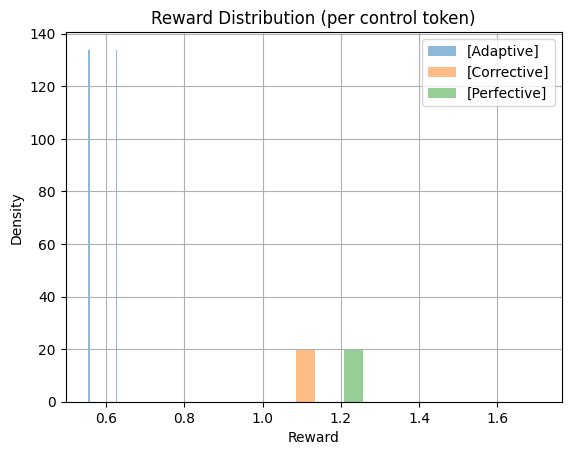

In [44]:
for ctrl_s in ctrl_str:
    vals = [
        r.item()
        for r, t in zip(rewards, task_list)
        if t == ctrl_s
    ]
    if len(vals) > 0:
        plt.hist(
            vals,
            bins=20,
            density=True,
            alpha=0.5,
            label=ctrl_s,
        )

plt.legend(loc="best")
plt.title("Reward Distribution (per control token)")
plt.xlabel("Reward")
plt.ylabel("Density")
plt.grid(True)
plt.show()

## Save model
Finally, we save the model to disk for later usage.

In [59]:
policy.save_pretrained("codet5-msgs-ctrl")
tokenizer.save_pretrained("codet5-msgs-ctrl")

('codet5-msgs-ctrl/tokenizer_config.json',
 'codet5-msgs-ctrl/special_tokens_map.json',
 'codet5-msgs-ctrl/vocab.json',
 'codet5-msgs-ctrl/merges.txt',
 'codet5-msgs-ctrl/added_tokens.json',
 'codet5-msgs-ctrl/tokenizer.json')

In [60]:
#发送多种类型的邮件
from email.mime.multipart import MIMEMultipart
import smtplib

from email.mime.text import MIMEText
msg_from = '915803745@qq.com'  # 发送方邮箱
passwd = 'vcuosuurrgkfbdai'   #就是上面的授权码
 
# to= ['g.zhang@gotion.com', 'j.tong@gotion.com'] #接受方邮箱
to= ['j.tong@gotion.com'] #接受方邮箱
#设置邮件内容
#MIMEMultipart类可以放任何内容
msg = MIMEMultipart()
conntent=f"{'成功'}"
#把内容加进去
msg.attach(MIMEText(conntent,'plain','utf-8'))
 
#设置邮件主题
msg['Subject']="PPO学习模型训练完毕"
 
#发送方信息
msg['From']=msg_from
 
#开始发送
 
#通过SSL方式发送，服务器地址和端口
s = smtplib.SMTP_SSL("smtp.qq.com", 465)
# 登录邮箱
s.login(msg_from, passwd)
#开始发送
s.sendmail(msg_from,to,msg.as_string())
print("强化学习模型训练完毕")

强化学习模型训练完毕
